## Analyze the effect of acoustic focusing for Figure 2e  
Data: 3D green channel image before reconstruction

## Libraries

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import tifffile
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["font.size"] = 6

## Functions

In [7]:
def int_projection(path, data):
    '''
    Calculate the sum of fluorescence intensity

    path: path of the data
    data: shared name of the data
    '''
    result = []
    number = ['', '_X1', '_X2', '_X3', '_X4', '_X5', '_X6', '_X7'] # suffix of the data

    for n in number:
        filename = data+n+'.fits'
        img = np.flip(fits.getdata(path+filename), axis=1) # inverte the images along z-axis (height)
        result.append(np.sum(img, axis=0))

    result = np.sum(np.stack(result), axis=0) # calculate the sum along y-axis (flow)
    return np.sum(result, axis=1) # calculate the sum along x-axis (width)

In [8]:
def make_img(path, file, start_frame, end_frame):
    '''
    Create images of the sum of fluorescence intensity

    path: path of the data
    file: input data (3D)
    start_frame: first frame
    end_frame: last frame
    '''
    img = np.flip(fits.getdata(path+file), axis=1)
    img = img[start_frame:end_frame, ...]

    return np.sum(img, axis=0)

In [9]:
def set_scalebar(ax, size, x_scale, vsize=2, borderpad=1, loc='lower right'):
    '''
    Set a scalebar in a image
    
    size: size in micrometers
    vsize: width of scale bar
    borderpad: distance of scale bar to edge of image
    '''
    scalebar = AnchoredSizeBar(ax.transData, size=size/x_scale, label=rf'{size} $\mu$$m$',
                               loc=loc, frameon=False, color='white', size_vertical=vsize, borderpad=borderpad, label_top=True,
                               fontproperties=fm.FontProperties(size=12))
    ax.add_artist(scalebar)

## Directories

In [16]:
data = '../data/3D/raw/'
result = '../result/'

## Analysis

### Calculating sum of intensity

In [11]:
result_on = int_projection(data, 'id551_MDCK_unit_acousticon_sheathoff_02_200Hz_405_250mW_488_150mW_488')

TypeError: int_projection() missing 1 required positional argument: 'data'

In [ ]:
result_off = int_projection(data, 'id551_MDCK_unit_acousticoff_sheathoff_01_200Hz_405_250mW_488_150mW_488')

In [9]:
np.save('../result/result_acousticon_sheathoff.npy', np.array(result_on))

In [10]:
np.save('../result/result_acousticoff_sheathoff_1.npy', np.array(result_off))

### Making figures

In [12]:
pixelsize = 6.5 # pixel size of the image sensor in um
mag = 200/9 # magnification rate of imaging
F_indexmismatch = 1.412 # axial elongation factor due to refractive-index mismatch of remote focusing

In [13]:
z_scale = F_indexmismatch * (pixelsize / mag)

In [15]:
zcoord = np.arange(350, 0, -1)
zcoord = zcoord * z_scale # convert z-coordnate to um scale

In [16]:
result_on = result_on[-350:]
result_off = result_off[-350:]

In [18]:
# normalize the sum of the intensity
result_on_normalized = (result_on - np.min(result_on)) / (np.max(result_on) - np.min(result_on))
result_off_normalized = (result_off - np.min(result_off))/ (np.max(result_off) - np.min(result_off))

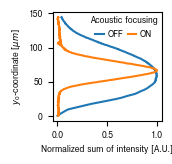

In [50]:
plt.figure(figsize=(1.41, 1.41))
plt.plot(result_off_normalized, zcoord, label='OFF')
plt.plot(result_on_normalized, zcoord, label='ON')
plt.legend(title = 'Acoustic focusing', ncol=2, columnspacing=0.5, handlelength=1, handletextpad=0.5, loc='upper right', borderaxespad=0.1, frameon=False)
plt.xlabel('Normalized sum of intensity [A.U.]')
plt.ylabel(r'$y_{o}$-coordinate $[\mu m]$')
plt.savefig('../result/intensity_acousticonoff.pdf', bbox_inches="tight", pad_inches=0.05)

### Making images

In [22]:
on_sum = make_img(data, 'id551_MDCK_unit_acousticon_sheathoff_02_200Hz_405_250mW_488_150mW_488_X1.fits', 500, 700)

In [23]:
off_sum = make_img(data, 'id551_MDCK_unit_acousticoff_sheathoff_01_200Hz_405_250mW_488_150mW_488.fits', 200, 400)

In [24]:
on_sum_normalized = (on_sum - np.min(on_sum)) / (np.max(on_sum) - np.min(on_sum))
off_sum_normalized = (off_sum - np.min(off_sum)) / (np.max(off_sum) - np.min(off_sum))

In [ ]:
on_sum_normalized = on_sum_normalized[-350:, :]
off_sum_normalized = off_sum_normalized[-350:, :]

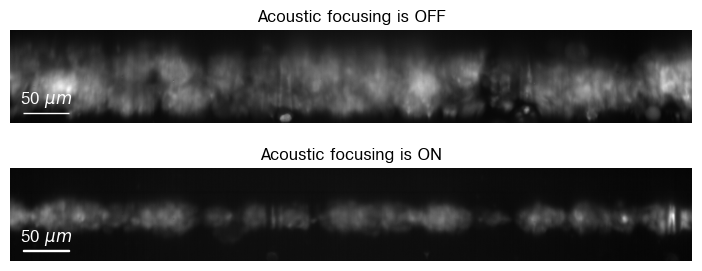

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3))
ax[0].imshow(off_sum_normalized, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('Acoustic focusing is OFF', size=12)
set_scalebar(ax[0], size=50, x_scale=pixelsize/mag, vsize=2, borderpad=0.5, loc='lower left')
ax[1].imshow(on_sum_normalized, cmap='gray')
ax[1].set_axis_off()
ax[1].set_title('Acoustic focusing is ON', size=12)
set_scalebar(ax[1], size=50, x_scale=pixelsize/mag, vsize=2, borderpad=0.5, loc='lower left')
plt.tight_layout()

plt.savefig('../result/sum_acousticonoff.pdf', bbox_inches="tight", pad_inches=0.05)

In [26]:
tifffile.imwrite('../result/sum_acousticoff.tif', off_sum_normalized)
tifffile.imwrite('../result/sum_acousticon.tif', on_sum_normalized)